# Problem Statement
With increasing number of mass shooting incidents at schools, malls and other public places across US of A, there is a need of effective monitoring systems that can identify potential dangers and alert beforehand. Law enforcement agencies that guard public places currently rely on technology like walk-through or handheld magnetometers, which detect changes in local magnetic fields.

The requirement is to create an AI powered gun detection system that can identify threats by connecting with the existing video surveillance cameras to reliably and rapidly recognize firearms and immediately trigger multi-channel alerts and automate pre-defined safety protocols.

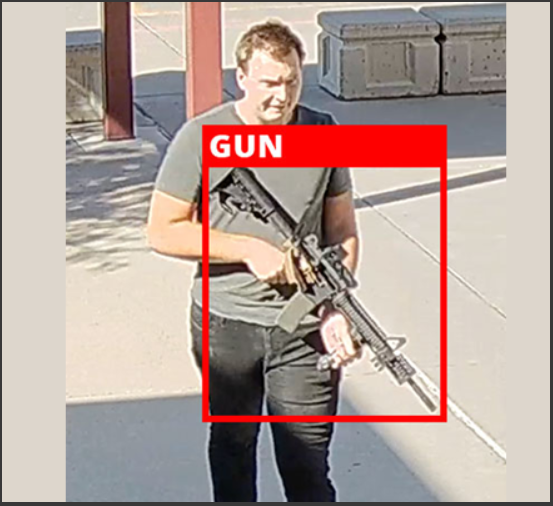

In [1]:
import os
import random
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# notebook configuration
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
# plt.rcParams['figure.figsize'] = (20, 10)

# Introduction To Object Detection
In Image classification, CNNs were developed to detect objects present anywhere in an image and assign them with a probability scores and labels. The class labels and probability scores are generally associated with the full image and care about the presence or absence of the object of interest in the image. 

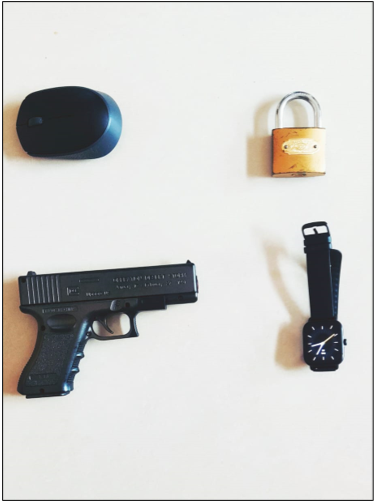

But what if there is need to find the location of the object of interest in the image or how many objects are present in the image?

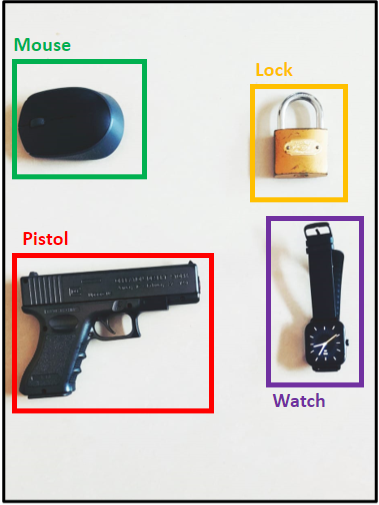

Object detection addresses these limitations by not only identifying the presence of objects but also pinpointing their exact locations within an image. This is typically achieved by drawing bounding boxes around the detected objects.

### Key differences from Image Classification
- Granularity: Image classification provides a label for the entire image, while object detection focuses on individual objects within the image.
- Output:
    - Image classification: Class label and probability score.
    - Object detection: Class label, probability score and bounding box coordinates.
- Spatial information: Object detection explicitly considers the spatial relationships between objects in the image.

### Applications of Object Detection
- Self-driving cars: Detecting pedestrians, vehicles and traffic signs.
- Surveillance systems: Identifying and tracking individuals or objects of interest.
- Medical image analysis: Detecting tumors or anomalies in medical images.
- Retail: Analyzing customer behavior and inventory management.
- Robotics: Enabling robots to interact with the environment.

In summary, object detection is a crucial task in Computer Vision that provides more detailed information about the content of an image compared to image classification. By combining object localization and classification, it enables a wide range of applications that require understanding the spatial arrangement of object in a scene.

# Loading And Exploring The Dataset

In [3]:
datapath = "pistol_data/"
!ls {datapath}

pistol_annotations pistol_images


In [4]:
annot_files = sorted(os.listdir(f"{datapath}pistol_annotations"))
img_files = sorted(os.listdir(f"{datapath}pistol_images"))

print(f'Total files: {len(annot_files)}')
print(f'Top 5: {annot_files[:5]}')
print(f'Top 5: {img_files[:5]}')

Total files: 3703
Top 5: ['1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt']
Top 5: ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']


In [5]:
# content in each of the annotation files
for annot_file in annot_files[0: 5]:
    with open(f"{datapath}pistol_annotations/{annot_file}", "r") as file:
        print(file.readlines())

['1 0.4253846153846154 0.2447973713033954 0.22153846153846152 0.2814895947426068']
['1 0.4983922829581993 0.4907407407407407 0.3665594855305466 0.4506172839506173']
['1 0.6466602129719264 0.28387096774193543 0.08131655372700872 0.05935483870967742']
['1 0.5747967479674796 0.39390243902439026 0.27804878048780485 0.3341463414634146']
['1 0.5061538461538462 0.4229559748427673 0.3353846153846154 0.3050314465408805']


Each `.txt` file inside pistol_annotations contains 4 point coordinated which represent the location of the Gun in the corresponding image as (`x_center`, `y_center`, `width`, `height`).

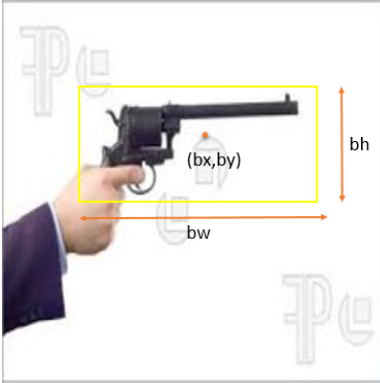

[1.0, 0.4253846153846154, 0.2447973713033954, 0.22153846153846152, 0.2814895947426068]
Image Resolution (416, 416, 3)
[1.0, 0.5188888888888888, 0.6283333333333333, 0.22, 0.27]
Image Resolution (416, 416, 3)
[1.0, 0.5672727272727273, 0.27322404371584696, 0.4290909090909091, 0.5027322404371584]
Image Resolution (416, 416, 3)
[1.0, 0.6140684410646388, 0.23177083333333331, 0.49809885931558934, 0.2864583333333333]
Image Resolution (416, 416, 3)
[1.0, 0.6994535519125683, 0.37999999999999995, 0.07650273224043716, 0.23636363636363636]
Image Resolution (416, 416, 3)


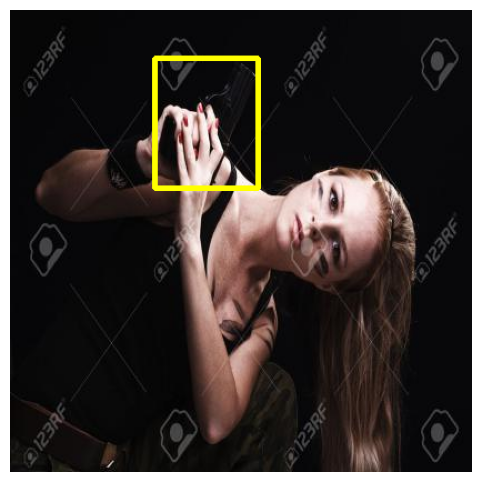

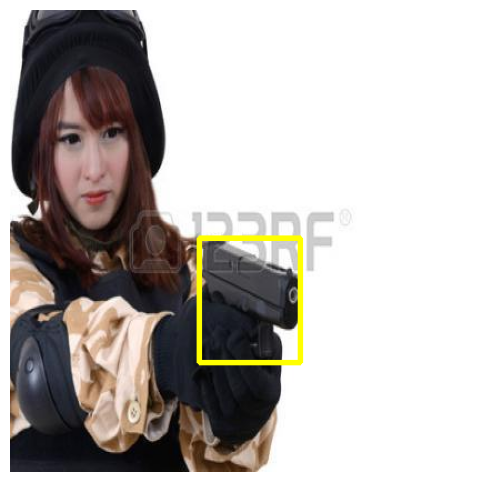

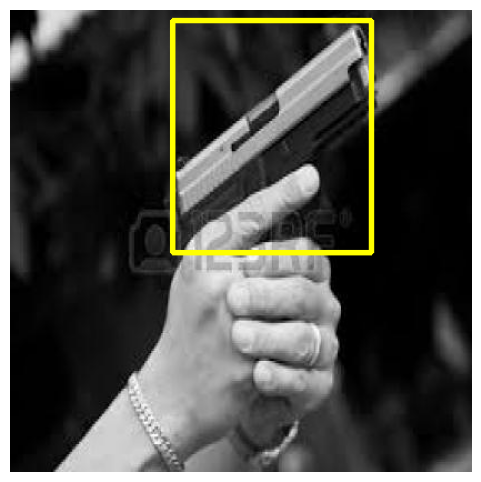

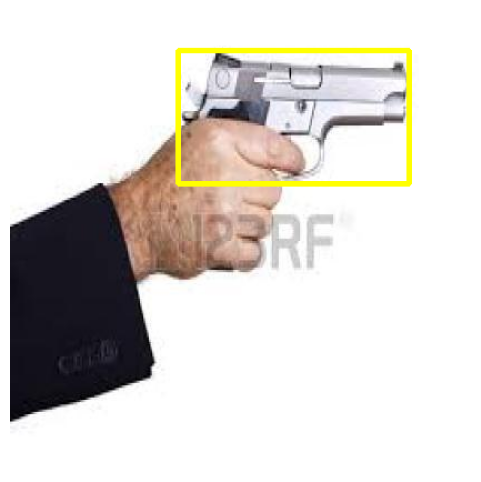

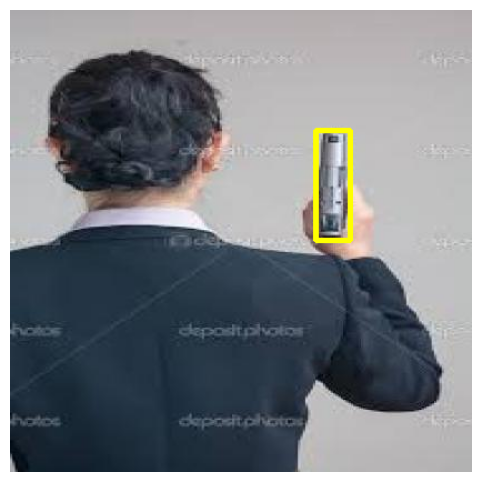

In [6]:
import cv2

img_h = 416
img_w = 416

def cv_coords(box):
    """
    This function will convert B.B cordinates from (X_center,Y_center,width,height) format
    to (x_start,y_start,x_end,y_end) required for cv2 to annotate rectangle on objects
    """
    x, y, w, h= box[1], box[2], box[3], box[4]
    x1, y1 = int((x - w/2) * img_w), int((y - h/2) * img_h)
    x2, y2 = int((x + w/2) * img_w), int((y + h/2) * img_h)
    return x1, y1, x2, y2

def plot_img_and_box(img, bbox):
    plt.figure(figsize = (6, 6))
    print("Image Resolution",img.shape)
    bbox = cv_coords(bbox)
    start_point = (bbox[0], bbox[1])
    end_point = (bbox[2], bbox[3])
    # convert to writable format (or make a copy)
    img = img.copy() 
    img = cv2.rectangle(img, start_point, end_point, (255, 255, 0), 3)
    plt.axis("off")
    plt.imshow(img)

for i in range(5):
    img_path = f"{datapath}pistol_images/{i+1}.jpg"
    label_path = f"{datapath}pistol_annotations/{i+1}.txt"

    img = plt.imread(img_path)

    with open(label_path, "r") as file:
        bbox = (file.readlines())
        bbox = [float(element) for element in bbox[0].split(" ")]
        print(bbox)

    plot_img_and_box(img, bbox)

# Classification + Localization
The CNN architecture can be modified for classification and localization, the final layers will have to be adapted to output both the class probability and the bounding box coordinates. The following is a common approach,
1. Feature extraction backbone: Retain the existing convolutional layers of the chosen CNN architecture (e.g., VGG, ResNet, EfficientNet) to extract features from the input image.
2. Dual-head output layer:
    - Classification head:
        - Add a fully connected (FC) layer with the number of units equal to the number of classes.
        - Apply a softmax activation function to obtain class probabilities.
    - Localization head:
        - Add another FC layer with four output units.
        - Each unit represents:
            - x-coordinate of the bounding box center.
            - y-coordinate of the bounding box center.
            - width of the bounding box.
            - height of the bounding box.
3. Loss function:
    - Classification loss: Use cateforical cross-entropy loss to measure the discrepancy between predicted and true class probabilities.
    - Localization loss: Use L1 or L2 loss (Mean Absolute Error or Mean Squared Error) to measure the difference between predicted and ground-truth bounding box coordinates.
    - Combined loss: Combine the classification and localization losses with appropriate weights.

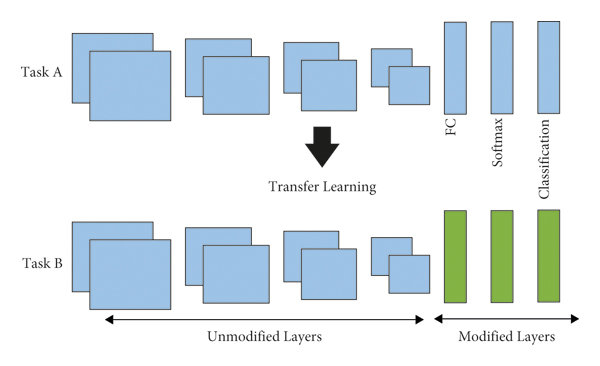

### Key points
- The feature extraction backbone provides a rich representation of the image.
- The dual-head output layer allows the network to simultaneously predict both the class and the bounding box.
- The choice of loss function is crucial for training the model effectively.

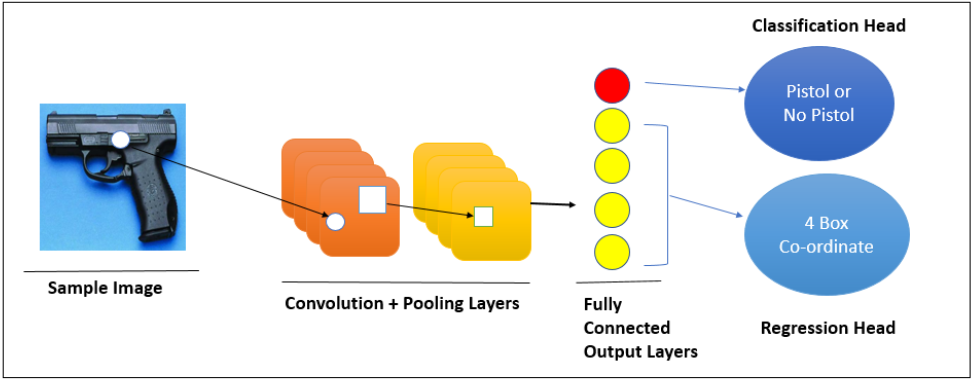

In [7]:
# loading the dataset into arrays
from tqdm.auto import tqdm

def return_bbox(label_path):
    """
    read and return bbox from text file
    """
    with open(label_path, "r") as file:
        bbox = (file.readlines())
        bbox = [float(element) for element in bbox[0].split(" ")]
        return bbox[0], bbox[1: ]

def return_image_label(filename):
    """
    read and return image as well as corresponding label and bbox from image file
    """
    try:
        img_path = f"{datapath}pistol_images/{filename}.jpg"
        image = plt.imread(img_path)
        label_path = f"{datapath}pistol_annotations/{filename}.txt"
        class_label, bbox_label = return_bbox(label_path)
        return True, image, class_label, bbox_label
    except Exception as e:
        print("Exception: ", filename, str(e))
        return False, None, None, None


### Looping over all the files present in directory to extract image, labels and bbox
images, class_labels, bbox_labels = [], [], []
for filename in tqdm(annot_files):
    filename = filename[: -4]
    status, image, class_label, bbox_label= return_image_label(filename)
    if status == True and image.shape == (416,416,3):
        images.append(image)
        class_labels.append(class_label)
        bbox_labels.append(bbox_label)


images, class_labels, bbox_labels = np.array(images),np.array(class_labels),np.array(bbox_labels)
images.shape, class_labels.shape, bbox_labels.shape

100%|██████████| 3703/3703 [00:03<00:00, 947.47it/s] 


((3703, 416, 416, 3), (3703,), (3703, 4))

In [8]:
class_label

1.0

In [9]:
bbox_labels

array([[0.42538462, 0.24479737, 0.22153846, 0.28148959],
       [0.49839228, 0.49074074, 0.36655949, 0.45061728],
       [0.64666021, 0.28387097, 0.08131655, 0.05935484],
       ...,
       [0.66423077, 0.51078799, 0.45153846, 0.815197  ],
       [0.49666667, 0.49450549, 0.92666667, 0.79120879],
       [0.48653846, 0.45345188, 0.97153846, 0.90481172]])

In [10]:
# frequency distribution of gun and no-gun class
np.unique(class_labels, return_counts = True)

(array([0., 1.]), array([ 999, 2704]))

There are 999 images with no guns and 2704 images with guns present in the frame.

In [11]:
# splitting the dataset into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_class, y_test_class, y_train_box, y_test_box = train_test_split(images, class_labels, bbox_labels, test_size = 0.30, random_state = 42)
x_train.shape, x_test.shape, y_train_class.shape, y_test_class.shape, y_train_box.shape, y_test_box.shape

((2592, 416, 416, 3),
 (1111, 416, 416, 3),
 (2592,),
 (1111,),
 (2592, 4),
 (1111, 4))

In [12]:
y_train_class

array([1., 0., 1., ..., 1., 1., 1.])

In [13]:
y_train_box

array([[0.41620112, 0.56560284, 0.24022346, 0.10992908],
       [0.        , 0.        , 0.        , 0.        ],
       [0.48333333, 0.50518519, 0.75555556, 0.89481481],
       ...,
       [0.496875  , 0.5       , 0.98125   , 0.95      ],
       [0.5       , 0.47757848, 0.996875  , 0.95067265],
       [0.517     , 0.51201201, 0.694     , 0.96996997]])

In [ ]:
import ssl



In [15]:
# creating the architecture to generate bbox coordinates along with class probability
ResNet101 = tf.keras.applications.ResNet101(weights = "imagenet", include_top = False, input_tensor = tf.keras.layers.Input(shape = (416, 416, 3)))

# setting trainable parameter to False
ResNet101.trainable = False

# adding some trainable dense layers
res_output = ResNet101.output
flat = tf.keras.layers.Flatten()(res_output)

# classification head
x1 = tf.keras.layers.Dense(128, activation = "relu")(flat)
x1 = tf.keras.layers.Dense(64, activation = "relu")(x1)
x1 = tf.keras.layers.Dense(32, activation = "relu")(x1)

# classification output: single class
class_out = tf.keras.layers.Dense(1, activation = "sigmoid", name = "class_output")(x1)

# regression head
x1 = tf.keras.layers.Dense(128, activation = "relu")(flat)
x1 = tf.keras.layers.Dense(64, activation = "relu")(x1)
x1 = tf.keras.layers.Dense(32, activation = "relu")(x1)

# regression output: 4 bbox coordinates
reg_out = tf.keras.layers.Dense(4, activation = "sigmoid", name = "box_output")(x1)

ResNet101_final = tf.keras.models.Model(ResNet101.input, [reg_out, class_out])

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)